## Imports

In [365]:
#!pip install -U dill==0.3.5.1
#!pip install -U tensorflow-io==0.27.0
#!pip install -U tensorflow-transform==1.11.0
#!pip install -U tensorflow==2.10.0
import tensorflow as tf
print(tf.__version__)

2.6.4


In [366]:
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, ShuffleSplit, StratifiedShuffleSplit
from sklearn.utils import indexable, _safe_indexing, shuffle
from sklearn.utils.validation import _num_samples
from math import ceil, floor
from itertools import chain
import warnings

In [367]:
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

plt.rc('font', size=16)

tfk = tf.keras
tfkl = tf.keras.layers

## Defines

### Seed

In [368]:
# Random seed for reproducibility
seed = 1337

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Constants

#### Imports

In [369]:
dataset_location = '/kaggle/input/training-dataset-homework2/'
x_name = 'x_train.npy'
y_name = 'y_train.npy'

#### Training

In [370]:
classes = 12
features = 6
input_shape = (None, 6)

batch_size = 64
epochs = 200

label_mapping = {
    "Wish" : 0,
    "Another" : 1,
    "Comfortably" : 2,
    "Money" : 3,
    "Breathe" : 4,
    "Time" : 5,
    "Brain" : 6,
    "Echoes" : 7,
    "Wearing" : 8,
    "Sorrow" : 9,
    "Hey" : 10,
    "Shine" : 11
}

### Utility Functions

#### Custom scipy

In [371]:
def _validate_shuffle_split(n_samples, test_size, train_size, default_test_size=None):
    """
    Validation helper to check if the test/test sizes are meaningful wrt to the
    size of the data (n_samples)
    """
    if test_size is None and train_size is None:
        test_size = default_test_size

    test_size_type = np.asarray(test_size).dtype.kind
    train_size_type = np.asarray(train_size).dtype.kind

    if (
        test_size_type == "i"
        and (test_size >= n_samples or test_size <= 0)
        or test_size_type == "f"
        and (test_size <= 0 or test_size >= 1)
    ):
        raise ValueError(
            "test_size={0} should be either positive and smaller"
            " than the number of samples {1} or a float in the "
            "(0, 1) range".format(test_size, n_samples)
        )

    if (
        train_size_type == "i"
        and (train_size >= n_samples or train_size <= 0)
        or train_size_type == "f"
        and (train_size <= 0 or train_size >= 1)
    ):
        raise ValueError(
            "train_size={0} should be either positive and smaller"
            " than the number of samples {1} or a float in the "
            "(0, 1) range".format(train_size, n_samples)
        )

    if train_size is not None and train_size_type not in ("i", "f"):
        raise ValueError("Invalid value for train_size: {}".format(train_size))
    if test_size is not None and test_size_type not in ("i", "f"):
        raise ValueError("Invalid value for test_size: {}".format(test_size))

    if train_size_type == "f" and test_size_type == "f" and train_size + test_size > 1:
        raise ValueError(
            "The sum of test_size and train_size = {}, should be in the (0, 1)"
            " range. Reduce test_size and/or train_size.".format(train_size + test_size)
        )

    if test_size_type == "f":
        n_test = ceil(test_size * n_samples)
    elif test_size_type == "i":
        n_test = float(test_size)

    if train_size_type == "f":
        n_train = floor(train_size * n_samples)
    elif train_size_type == "i":
        n_train = float(train_size)

    if train_size is None:
        n_train = n_samples - n_test
    elif test_size is None:
        n_test = n_samples - n_train

    if n_train + n_test > n_samples:
        raise ValueError(
            "The sum of train_size and test_size = %d, "
            "should be smaller than the number of "
            "samples %d. Reduce test_size and/or "
            "train_size." % (n_train + n_test, n_samples)
        )

    n_train, n_test = int(n_train), int(n_test)

    if n_train == 0:
        raise ValueError(
            "With n_samples={}, test_size={} and train_size={}, the "
            "resulting train set will be empty. Adjust any of the "
            "aforementioned parameters.".format(n_samples, test_size, train_size)
        )

    return n_train, n_test


In [372]:
def my_train_test_split(
    *arrays,
    test_size=None,
    train_size=None,
    random_state=None,
    shuffle=True,
    stratify=None,
):
    n_arrays = len(arrays)
    if n_arrays == 0:
        raise ValueError("At least one array required as input")

    arrays = indexable(*arrays)

    n_samples = _num_samples(arrays[0])
    n_train, n_test = _validate_shuffle_split(
        n_samples, test_size, train_size, default_test_size=0.25
    )

    if shuffle is False:
        if stratify is not None:
            raise ValueError(
                "Stratified train/test split is not implemented for shuffle=False"
            )

        train = np.arange(n_train)
        test = np.arange(n_train, n_train + n_test)

    else:
        if stratify is not None:
            CVClass = StratifiedShuffleSplit
        else:
            CVClass = ShuffleSplit

        cv = CVClass(test_size=n_test, train_size=n_train, random_state=random_state)

        train, test = next(cv.split(X=arrays[0], y=stratify))

    return list(
        chain.from_iterable(
            (train, test) for a in arrays
        )
    )


#### Windowing

In [373]:
def unroll_splice(x, y):
    unique_labels, labels_count = np.unique(y, return_counts=True)
    x_splices = [[] for _ in range(len(unique_labels))]
    y_splices = [label for label in unique_labels]
    
    for x_samples, label in zip(x, y):
        x_splices[label].extend(x_samples.tolist())
        
    return x_splices, y_splices

In [374]:
def build_sequences(
    x, y, 
    window, # window: new window size
    stride, # stride: interval between windows
    padding = True, # padding: if False, throw an error if padding is required
    preserve_window_size = False # preserve_window_size: if True, only generate new samples inside the old window
):
    
    old_window = np.shape(x)[1]
    overlap = window - stride
    jump_length = window - overlap
    
    assert overlap >= 0
    
    dataset = []
    labels = []
    
    if preserve_window_size:
        assert window <= old_window
        x_iter, y_iter = x, y
    else:
        x_iter, y_iter = unroll_splice(x, y)
        
    for samples, label in zip(x_iter, y_iter):
        
        new_samples = samples.copy()
        
        # Padding (not guaranteed to work)
        if len(samples) % jump_length:
            if padding:
                padding_len = overlap
                padding = [[0 for _ in range(np.shape(samples)[1])] for _ in range(padding_len)]
                padding.extend(samples)
                new_samples = padding
            else:
                print("NO PADDING >:(")
                assert False
                
        n_new_samples = len(new_samples) - window + 1
        
        for i in np.arange(0, n_new_samples, stride):
            dataset.append(new_samples[i:i + window][:])
            labels.append(label)
    
    return dataset, labels

#### Feature tinkering

In [375]:
def drop_features(x, features):
    dataset = []
    for window in x:
        window = window.T
        window = [ value for i, value in enumerate(window) if i not in features ]
        dataset.append(np.array(window).T)
    return np.array(dataset)

In [376]:
def generate_amplitude_feature_normalize(
    x,
    window_amp,
    features = [i for i in range(features)], 
):
    augmented_dataset = []
    
    for window in x:
        window_size = np.shape(window)[0]
        window = window.T
        new_window = []
        new_new_window = []

        for i, f_samples in enumerate(window):
            if i in features:

                f_newsamples = []

                for i in range(window_size):
                    i_ = i - window_amp if i - window_amp > 0 else 0
                    j_ = i + window_amp if i + window_amp <= window_size else window_size
                    f_newsamples.append(np.mean(f_samples[i_:j_]))

                f_samples /= np.max(np.abs(f_samples))
                new_new_window.append(f_newsamples)
            new_window.append(f_samples)
        window = np.concatenate((new_window, new_new_window))
        window = window.T
        augmented_dataset.append(window)

    return np.array(augmented_dataset)

In [377]:
def generate_frequence_feature(
    x,
    features = [i for i in range(features)], 
):
    augmented_dataset = []
    
    for window in x:
        window_size = np.shape(window)[0]
        window = window.T
        new_window = []
        new_new_window = []

        for i, f_samples in enumerate(window):
            if i in features:

                f_newsamples = []
                old = 0
                
                for sample in f_samples:
                    f_newsamples.append(sample-old)
                    old = sample
                    
                new_new_window.append(f_newsamples)
            new_window.append(f_samples)
        window = np.concatenate((new_window, new_new_window))
        window = window.T
        augmented_dataset.append(window)

    return np.array(augmented_dataset)

#### DAUG

In [378]:
def daug_reverse(
    x, y,
    size = 0.5, # Size of the inverted section from 0 to 1
    frequence = 0.5, # Frequence of DAUG on dataset
    only_augmented = False, # Return only augmented entries
    features = [i for i in range(features)], classes = [i for i in range(classes)], # Masks for excluding features/classes
    seed = 0
):
    rng = random.Random(seed)
    augmented_dataset = []
    labels = []
    
    for window, label in zip(x, y):
        aug = False
        if label in classes and rng.uniform(0, 1) <= frequence:
            
            aug = True
            window_size = np.shape(window)[0]
            window = window.T
            new_window = []
            
            # Calculate reversing interval
            reverse_size = int(np.rint(size * window_size))
            reverse_size = reverse_size if reverse_size > 0 else 2
            reverse_start = rng.randint(0, window_size - reverse_size)
            reverse_end = reverse_start + reverse_size
            
            for i, f_samples in enumerate(window):
                if i in features:
                    f_samples = f_samples.tolist()
                    
                    # Reverse
                    f_samples[reverse_start:reverse_end] = f_samples[reverse_start:reverse_end][::-1]
                    
                new_window.append(f_samples)
            window = np.array(new_window).T
            
        if only_augmented or aug:
            augmented_dataset.append(window)
            labels.append(label)
            
    return np.array(augmented_dataset), np.array(labels)

In [379]:
def daug_noise(
    x, y, 
    mean = 0, variance = 1, # Noise parameters
    frequence = 0.5, # Frequence of DAUG on dataset
    only_augmented = False, # Return only augmented entries
    features = [i for i in range(features)], classes = [i for i in range(classes)], # Masks for excluding features/classes
    seed = 0
):
    rng = random.Random(seed)
    augmented_dataset = []
    labels = []
    
    for window, label in zip(x, y):
        aug = False
        if label in classes and rng.uniform(0, 1) <= frequence:
            
            aug = True
            window_size = np.shape(window)[0]
            window = window.T
            new_window = []
            
            for i, f_samples in enumerate(window):
                if i in features:
                    
                    # Adding noise
                    f_samples + np.random.normal(mean, variance, window_size)
                    
                new_window.append(f_samples)
            window = np.array(new_window).T
            
        if only_augmented or aug:
            augmented_dataset.append(window)
            labels.append(label)
            
    return np.array(augmented_dataset), np.array(labels)

In [380]:
def get_cutmix_element(x, y, label, rng):
    pool = [w for w, l in zip(x,y) if l == label]
    idx = rng.randint(0, len(pool) - 1)
    return pool[idx].T

def daug_cutmix(
    x, y, 
    min_max_size = (0.2, 0.4), # Minimum and maximum size for cutmix source, this is ignore if full_embed = True
    full_embed = False, # Embeds all of the cutmix source entry into the receiving (WARNING! It changes the size of the entry, not recommended with custom feature masks)
    change_for_each_feature = False, # If true, eachs feature gets its cutmix from a different source/size/position
    frequence = (0.5, 0.5), # Frequence of DAUG on dataset and frequence of DAUG on features
    only_augmented = False, # Return only augmented entries
    features = [i for i in range(features)], classes = [i for i in range(classes)], # Masks for excluding features/classes
    seed = 0
):
    rng = random.Random(seed)
    augmented_dataset = []
    labels = []
    
    for window, label in zip(x, y):
        aug = False
        if label in classes and rng.uniform(0, 1) <= frequence[0]:
            aug = True
            window_size = np.shape(window)[0]
            window = window.T
            new_window = []
            
            # Get new cutmix source element
            cutmix_el = get_cutmix_element(x, y, label, rng)
            
            # Calculate cutmix source size + position and cutmix destination position
            if full_embed:
                cutmix_position = rng.randint(0, window_size)
            else:
                cutmix_size = int(np.rint(rng.uniform(*min_max_size) * window_size))
                cutmix_size = cutmix_size if cutmix_size > 0 else 1
                cutmix_position_s = rng.randint(0, window_size - cutmix_size)
                cutmix_position_r = rng.randint(0, window_size - cutmix_size)
                
            
            for i, f_samples in enumerate(window):
                if i in features and rng.uniform(0, 1) <= frequence[1]:
                    
                    # Apply cutmix to feature
                    if full_embed:
                        np.insert(f_samples, cutmix_position, cutmix_el[i])
                    else:
                        f_samples[cutmix_position_r:cutmix_position_r + cutmix_size] = cutmix_el[i][cutmix_position_s:cutmix_position_s + cutmix_size]
                        
                    # Change cutmix parameters if the source is different for each feature
                    if change_for_each_feature:
                        cutmix_size = int(np.rint(rng.uniform(*min_max_size) * window_size))
                        cutmix_size = cutmix_size if cutmix_size > 0 else 1
                        cutmix_el = get_cutmix_element(x, y, label, rng)
                        cutmix_position_s = rng.randint(0, window_size - cutmix_size)
                        cutmix_position_r = rng.randint(0, window_size - cutmix_size)
                        
                new_window.append(f_samples)
            window = np.array(new_window).T
            
        if only_augmented or aug:
            augmented_dataset.append(window)
            labels.append(label)
            
    return np.array(augmented_dataset), np.array(labels)

#### Visualization

In [381]:
def inspect_multivariate(x, y, idx=None):
    if(idx == None):
        idx = np.random.randint(0, len(x))
    print(f"{y[idx]} --> {np.argmax(y[idx])}")
    df = pd.DataFrame(x[idx,:,:])
    df.plot(subplots=True, figsize=(17, 9))
    plt.show()

In [382]:
def inspect_timewise(total, bars=True, features=[i for i in range(6)]):
    vis = np.transpose(np.concatenate(total))
    print(vis.shape)
    plt.rcParams["figure.figsize"] = [15, 30]
    plt.rcParams["figure.autolayout"] = True
    fig, axs = plt.subplots(len(features))
    ax_idxs = {i:n for n, i in enumerate(features)}
    for idx in features:
        ax_idx = ax_idxs[idx]
        df = pd.DataFrame(vis[idx,:])
        axs[ax_idx].plot(df)
        if bars:
            l=0
            for i in label_counts:
                l = l + i*36
                axs[ax_idx].axvline(l, color='red')
            axs[ax_idx].text(s = f"Feature {idx+1}", x = 80000, y = 30000)
    plt.show()

In [383]:
def evaluate_classes_performance(model, x_val, y_val):
    data_list = []
    label_list = []
    batch_index = 0

    data_array = np.array(x_val)
    label_array = np.array(y_val)   
    label_values = np.argmax(label_array, axis=1)
    predictions = model.predict(data_array)
    predictions_label = np.argmax(predictions, axis=1)
    
    report = classification_report(label_values, predictions_label)
    print(report)
    
    # Compute the confusion matrix
    cm = confusion_matrix(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))

    # Compute the classification metrics
    accuracy = accuracy_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))
    precision = precision_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    recall = recall_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    f1 = f1_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    print('Accuracy:', accuracy.round(4))
    print('Precision:', precision.round(4))
    print('Recall:', recall.round(4))
    print('F1:', f1.round(4))

    # Plot the confusion matrix
    plt.figure(figsize=(10,8))
    sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
    plt.xlabel('True labels')
    plt.ylabel('Predicted labels')
    plt.show()

In [384]:
def plot_history(history):
    best_epoch = np.argmax(history['val_accuracy'])
    plt.figure(figsize=(17,4))
    plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
    plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
    plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
    plt.title('Categorical Crossentropy')
    plt.legend()
    plt.grid(alpha=.3)
    plt.show()

    plt.figure(figsize=(17,4))
    plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
    plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
    plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
    plt.title('Accuracy')
    plt.legend()
    plt.grid(alpha=.3)
    plt.show()

    plt.figure(figsize=(17,4))
    plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
    plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
    plt.legend()
    plt.grid(alpha=.3)
    plt.show()

## Load dataset

In [385]:
x_total = np.load(dataset_location + x_name)
y_total = np.load(dataset_location + y_name)

### Preprocessing

In [386]:
# Weight classes
class_weights = {}
_, label_counts = np.unique(y_total, return_counts=True)
class_mean = sum(label_counts) / len(label_counts)
for i, n in enumerate(label_counts):
    class_weights[i] = (1 / n) * class_mean
print(class_weights)

{0: 5.953431372549019, 1: 1.6456639566395665, 2: 0.7496913580246913, 3: 0.5312773403324584, 4: 3.264784946236559, 5: 1.3229847494553377, 6: 0.6466986155484558, 7: 2.9767156862745097, 8: 1.6868055555555554, 9: 0.2605105105105105, 10: 2.628787878787879, 11: 3.9689542483660127}


In [387]:
split_masks = my_train_test_split(
    x_total,
    y_total,
    test_size=0.2,
    stratify=y_total,
    random_state=seed
)

for mask in split_masks:
    mask.sort()

x_val = x_total[split_masks[1]]
x_train = np.delete(x_total, split_masks[1], axis=0)

y_val = y_total[split_masks[3]]
y_train = np.delete(y_total, split_masks[3], axis=0)

In [388]:
# Sanity checks
assert (split_masks[0]==split_masks[2]).all() and (split_masks[1]==split_masks[3]).all()
assert np.intersect1d(split_masks[0], split_masks[1]).size == 0
assert len(split_masks[0]) + len(split_masks[1]) == len(x_total)
assert np.array_equal(x_train, np.squeeze(x_total[split_masks[0]]))

In [389]:
x_train, y_train = build_sequences(x_train, y_train, window=36, stride=1, padding=False, preserve_window_size=False)
x_train = np.array(x_train)
y_train = np.array(y_train)

In [390]:
%%capture
shuffle(x_train, y_train, random_state=seed)

### DAUG pipeline

In [391]:
x_train = generate_frequence_feature(x_train)
x_val = generate_frequence_feature(x_val)

x_train = generate_amplitude_feature_normalize(x_train, 3, [0, 1, 2, 3, 4, 5])
x_val = generate_amplitude_feature_normalize(x_val, 3, [0, 1, 2, 3, 4, 5])

# Drop original features
# x_train = drop_features(x_train, [0, 1, 2, 3, 4, 5])
# x_val = drop_features(x_val, [0, 1, 2, 3, 4, 5])

# Adapt to number of features
input_shape = (None, 18)

In [392]:
# x_train, y_train = daug_reverse(x_train, y_train, 1, 0.3, False, seed=seed)
x_train_aug1, y_train_aug1 = daug_reverse(x_train, y_train, 1, 1, True, classes = [1, 3, 4, 5, 7, 11], features = [i for i in range(6)], seed=seed)
#np.append(x_train, x_train_aug1)
#np.append(y_train, y_train_aug1)
#x_train, y_train = daug_noise(x_train, y_train, 10, 1, 0.2, False, seed=seed)
x_train_aug2, y_train_aug2 = daug_noise(x_train_aug1, y_train_aug1, 0, 1, 1, True, features = [i for i in range(6)], seed=seed)
#np.append(x_train, x_train_aug2)
#np.append(y_train, y_train_aug2)
#x_train, y_train = daug_cutmix(x_train, y_train, (0.2, 0.5), False, False, (0.1, 1), False, seed=seed)
x_train_aug3, y_train_aug3 = daug_cutmix(x_train_aug2, y_train_aug2, (_, _), True, False, (1, 1), True, features = [i for i in range(6)], seed=seed)
np.append(x_train, x_train_aug3)
np.append(y_train, y_train_aug3)

shuffle(x_train, y_train, random_state=seed)
print(":D Stop shuffle from printing 1km of stuff")

:D Stop shuffle from printing 1km of stuff


### One hot

In [393]:
y_train = tfk.utils.to_categorical(y_train)
y_val = tfk.utils.to_categorical(y_val)

### Normalization

In [394]:
# Deprecated??
# Norm on the 36-dimension
# x_val /= np.max(np.abs(x_train), axis=0)
# x_train /= np.max(np.abs(x_train), axis=0)

# Norm on the 6-dimension
# x_val /= np.max(np.max(np.abs(x_train), axis=0))
# x_train /= np.max(np.max(np.abs(x_train), axis=0))

### Visualization

In [395]:
print(x_train.shape)
print(y_train.shape)

print(x_val.shape)
print(y_val.shape)

(69528, 36, 18)
(69528, 12)
(486, 36, 18)
(486, 12)


[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] --> 2


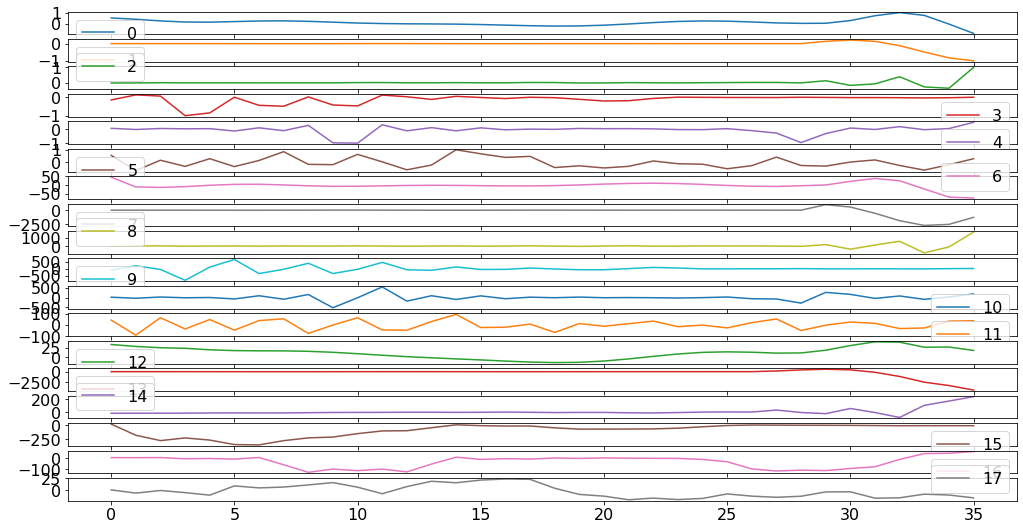

In [396]:
#inspect_timewise(x_total)
inspect_multivariate(x_train, y_train)

## Model

In [397]:
def build_LSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    
    # Preprocessing
    pre = input_layer
    pre = tf.keras.layers.Normalization(axis=2, name="Norm")(pre)
    
    # Feature extractor
    lstm = pre
    lstm = tfkl.LSTM(128, return_sequences=True)(lstm)
    lstm = tfkl.LSTM(128)(lstm)
    lstm = tfkl.Dropout(.5, seed=seed)(lstm)
    
    # Classifier
    classifier = lstm
    classifier = tfkl.Dense(128, activation='relu')(classifier)
    classifier = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    output_layer = classifier
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [398]:
def build_BiLSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    
    # Preprocessing
    pre = input_layer
    pre = tf.keras.layers.Normalization(axis=2, name="Norm")(pre)

    # Feature extractor
    bilstm = pre
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(bilstm)
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(bilstm)
    bilstm = tfkl.Bidirectional(tfkl.LSTM(256))(bilstm)
    bilstm = tfkl.Dropout(.5, seed=seed)(bilstm)

    # Classifier
    classifier = bilstm
    classifier = tfkl.Dense(128, activation='relu')(classifier)
    classifier = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    output_layer = classifier
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [399]:
def build_old1DCNN_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    
    pre = input_layer
    pre = tf.keras.layers.Normalization(axis=2, name="Norm")(pre)

    # Feature extractor
    cnn = pre
    cnn = tfkl.Conv1D(64, 3, padding='same', activation='relu')(cnn)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Dropout(.2, seed=seed)(cnn)
    cnn = tfkl.Conv1D(64, 3, padding='same', activation='relu')(cnn)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Dropout(.2, seed=seed)(cnn)
    cnn = tfkl.Conv1D(64, 3, padding='same', activation='relu')(cnn)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Dropout(.2, seed=seed)(cnn)
    cnn = tfkl.Conv1D(64, 3, padding='same', activation='relu')(cnn)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Dropout(.2, seed=seed)(cnn)
    cnn = tfkl.Conv1D(64, 3, padding='same', activation='relu')(cnn)
    cnn = tfkl.GlobalAveragePooling1D()(cnn)
    cnn = tfkl.Dropout(.2, seed=seed)(cnn)

    # Classifier
    classifier = cnn
    classifier = tfkl.Dense(
        128, activation='relu',
        kernel_regularizer=tfk.regularizers.L1(0.01),
        activity_regularizer=tfk.regularizers.L2(0.01)
    )(classifier)
    classifier = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    output_layer = classifier
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [400]:
def build_1DCNN_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    
    pre = input_layer
    pre = tf.keras.layers.Normalization(axis=2, name="Norm")(pre)

    # Feature extractor
    cnn = pre
    cnn = tfkl.Conv1D(128, 3, padding='same', activation='relu')(cnn)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Dropout(.1, seed=seed)(cnn)
    cnn = tfkl.Conv1D(128, 3, padding='same', activation='relu')(cnn)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Dropout(.1, seed=seed)(cnn)
    cnn = tfkl.Conv1D(128, 3, padding='same', activation='relu')(cnn)
    cnn = tfkl.MaxPooling1D()(cnn)
    #cnn = tfkl.GlobalAveragePooling1D()(cnn)
    cnn = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(cnn)
    cnn = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(cnn)
    cnn = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(cnn)
    cnn = tfkl.Bidirectional(tfkl.LSTM(128))(cnn)
    
    
    cnn = tfkl.Dropout(.4, seed=seed)(cnn)

    # Classifier
    classifier = cnn
    classifier = tfkl.Dense(
        128, activation='relu',
        kernel_regularizer=tfk.regularizers.L1(0.01),
        activity_regularizer=tfk.regularizers.L2(0.01)
    )(classifier)
    classifier = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    output_layer = classifier
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [401]:
#model = build_LSTM_classifier(input_shape, classes)
# model = build_BiLSTM_classifier(input_shape, classes)
# model = build_1DCNN_classifier(input_shape, classes)   # BEST ONE
model = build_old1DCNN_classifier(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, None, 18)]        0         
_________________________________________________________________
Norm (Normalization)         (None, None, 18)          37        
_________________________________________________________________
conv1d_35 (Conv1D)           (None, None, 64)          3520      
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, None, 64)          0         
_________________________________________________________________
dropout_36 (Dropout)         (None, None, 64)          0         
_________________________________________________________________
conv1d_36 (Conv1D)           (None, None, 64)          12352     
_________________________________________________________________
max_pooling1d_29 (MaxPooling (None, None, 64)          0     

## Training

### Adapt preprocessing layers

In [402]:
model.get_layer("Norm").adapt(x_train)

### Train

In [403]:
history = model.fit(
    x = x_train,
    y = y_train,
    validation_data = (x_val, y_val),
    batch_size = batch_size,
    epochs = epochs,
    #class_weight = class_weights,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=10, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
1087/1087 [==============================] - 7s 5ms/step - loss: 2.1287 - accuracy: 0.4710 - val_loss: 1.4350 - val_accuracy: 0.5679
Epoch 2/200
1087/1087 [==============================] - 6s 5ms/step - loss: 1.3484 - accuracy: 0.5892 - val_loss: 1.2806 - val_accuracy: 0.6399
Epoch 3/200
1087/1087 [==============================] - 6s 5ms/step - loss: 1.2018 - accuracy: 0.6410 - val_loss: 1.2243 - val_accuracy: 0.6317
Epoch 4/200
1087/1087 [==============================] - 6s 6ms/step - loss: 1.1125 - accuracy: 0.6695 - val_loss: 1.1823 - val_accuracy: 0.6667
Epoch 5/200
1087/1087 [==============================] - 6s 5ms/step - loss: 1.0440 - accuracy: 0.6929 - val_loss: 1.2488 - val_accuracy: 0.6646
Epoch 6/200
1087/1087 [==============================] - 6s 5ms/step - loss: 0.9983 - accuracy: 0.7073 - val_loss: 1.1951 - val_accuracy: 0.6626
Epoch 7/200
1087/1087 [==============================] - 6s 5ms/step - loss: 0.9572 - accuracy: 0.7175 - val_loss: 1.1665 - val_ac

## Visualize Results

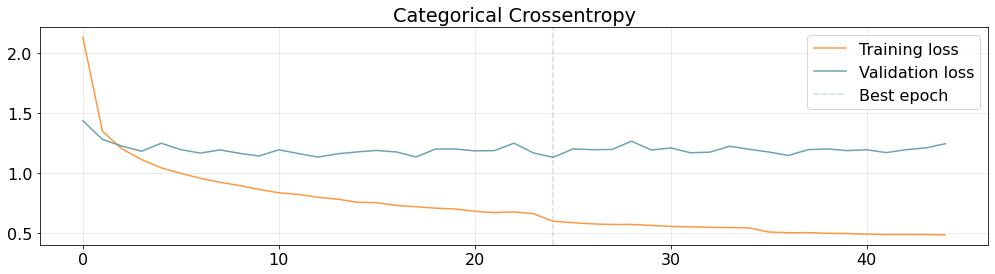

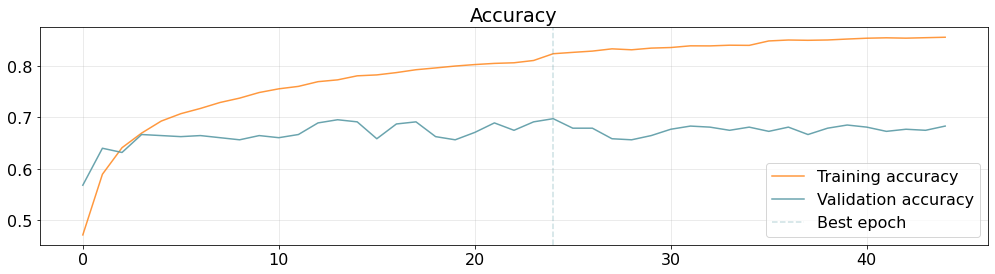

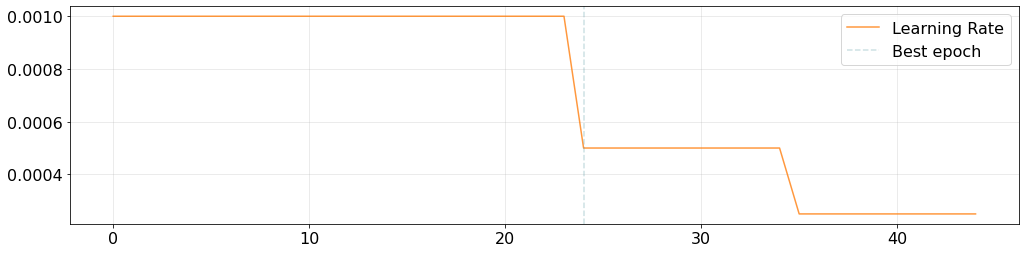

In [404]:
plot_history(history)

              precision    recall  f1-score   support

           0       1.00      0.43      0.60         7
           1       0.56      0.56      0.56        25
           2       0.94      0.89      0.91        54
           3       0.45      0.51      0.48        76
           4       0.00      0.00      0.00        12
           5       0.33      0.26      0.29        31
           6       0.85      0.89      0.87        63
           7       0.62      0.36      0.45        14
           8       1.00      0.83      0.91        24
           9       0.70      0.83      0.76       155
          10       1.00      0.93      0.97        15
          11       0.60      0.30      0.40        10

    accuracy                           0.70       486
   macro avg       0.67      0.57      0.60       486
weighted avg       0.68      0.70      0.68       486

Accuracy: 0.6975
Precision: 0.6718
Recall: 0.5661
F1: 0.6004


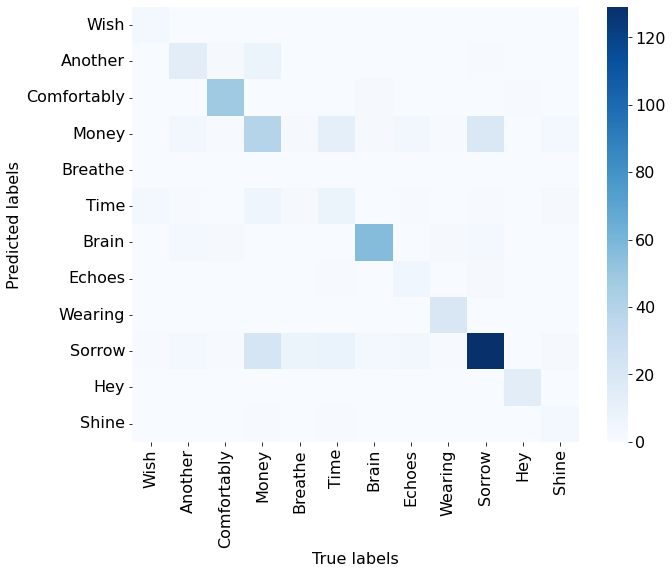

In [405]:
evaluate_classes_performance(model, x_val, y_val)

## Save

In [406]:
#import shutil
#model.save('ANN_Homework2_Model')
#shutil.make_archive("ANN_Homework2_Model", 'zip', '/kaggle/working/ANN_Homework2_Model')